# Dataset and context/content from https://www.kaggle.com/spscientist/students-performance-in-exams

# Context

Marks secured by the students

# Content

This data set consists of the marks secured by the students in various subjects.

# Acknowledgements

http://roycekimmons.com/tools/generated_data/exams

---

# Data import and setup:

In [1]:
# import relevant libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from scipy.stats import shapiro, levene, probplot
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# set font sizes for future plotting

SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# import data and inspect

data = pd.read_csv(r'StudentsPerformance.csv')

print(data.shape)

data.head()

(1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
# any missing entries?

data.isnull().any()

gender                         False
race/ethnicity                 False
parental level of education    False
lunch                          False
test preparation course        False
math score                     False
reading score                  False
writing score                  False
dtype: bool

# Aim:

To test the statistical (null) hypothesis that gender, race/ethnicity, and the parental level of education has no effect on the exam scores of children.

# Assumptions:

Comparing the means of different groups is possible through analysis of variance (ANOVA) tests. These tests have three main assumptions.

1. Independence. Each individual observation must only be in one group of a particular independent variable.

2. Normality. Each set of observations within a group should be normally distributed. This can be checked with the Shapiro-Wilk test.

3. Equality of variance between groups. This can be checked with Levene's test.

Both the Shapiro-Wilk and Levene's test set up null hypotheses that the data IS normally distributed/has equality of variance between groups. We will set an alpha of 0.01 for both, for a confidence level of 99%.

---

# Before we get started, let's have a quick look at some aggregates:

In [91]:
data.groupby('gender')['math score'].agg(['mean', 'std', 'count']).round(2)

,mean,std,count
gender,,,
female,63.63,15.49,518
male,68.73,14.36,482


In [92]:
data.groupby('race/ethnicity')['math score'].agg(['mean', 'std', 'count']).round(2)

,mean,std,count
race/ethnicity,,,
group A,61.63,14.52,89
group B,63.45,15.47,190
group C,64.46,14.85,319
group D,67.36,13.77,262
group E,73.82,15.53,140


In [93]:
data.groupby('parental level of education')['math score'].agg(['mean', 'std', 'count']).round(2)

,mean,std,count
parental level of education,,,
associate's degree,67.88,15.11,222
bachelor's degree,69.39,14.94,118
high school,62.14,14.54,196
master's degree,69.75,15.15,59
some college,67.13,14.31,226
some high school,63.50,15.93,179


---

# Test if the ANOVA assumptions are valid for this data:

# Test for independence

In [13]:
print(data['race/ethnicity'].unique())
print(data.gender.unique())
print(data['parental level of education'].unique())

['group B' 'group C' 'group A' 'group D' 'group E']
['female' 'male']
["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']


All groups we are interested in testing show no overlap (e.g. no observations with 'groups B *and* D' etc.), so the assumption of independence has been met/satisfied.

---

# We will now test for normality and equality of variance between groups, for each independent variable. 

# Test for normality in race/ethnicity groups

In [6]:
# Using the Shapiro-Wilk test, find the p-values for each group and exam score, then compare them to the 
# chosen alpha of 0.01

# Shapiro-Wilk null hypothesis is that the data DOES follow normality
# reject the null hypothesis if the p-value is lower than the alpha

math_p_vals = []
read_p_vals = []
write_p_vals = []

for i in list(data['race/ethnicity'].unique()):
    math_p_vals.append(shapiro(data[data['race/ethnicity'] == i]['math score']))
    read_p_vals.append(shapiro(data[data['race/ethnicity'] == i]['reading score']))    
    write_p_vals.append(shapiro(data[data['race/ethnicity'] == i]['writing score']))

print('The following results for each exam are printed in alphabetical order per group (A-E):\n')    

for p in math_p_vals:
    if p[1] < 0.01:
        print('W-value:', round(p[0], 3), 'p-value:', round(p[1], 3), 
              'reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: not normal')
    else:
        print('W-value:', round(p[0], 3), 'p-value:', round(p[1], 3), 
              'fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: normal')

print()
        
for p in read_p_vals:
    if p[1] < 0.01:
        print('W-value:', round(p[0], 3), 'p-value:', round(p[1], 3),
              'reject SW NH for reading scores: not normal')
    else:
        print('W-value:', round(p[0], 3), 'p-value:', round(p[1], 3),
              'fail to reject SW NH for reading scores: normal')
        
print()    

for p in write_p_vals:
    if p[1] < 0.01:
        print('W-value:', round(p[0], 3), 'p-value:', round(p[1], 3),
              'reject SW NH for writing scores: not normal')
    else:
        print('W-value:', round(p[0], 3), 'p-value:', round(p[1], 3),
              'fail to reject SW NH for writing scores: normal')

The following results for each exam are printed in alphabetical order per group (A-E):

W-value: 0.981 p-value: 0.01 fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: normal
W-value: 0.989 p-value: 0.017 fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: normal
W-value: 0.992 p-value: 0.855 fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: normal
W-value: 0.99 p-value: 0.059 fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: normal
W-value: 0.977 p-value: 0.018 fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: normal

W-value: 0.986 p-value: 0.049 fail to reject SW NH for reading scores: normal
W-value: 0.989 p-value: 0.013 fail to reject SW NH for reading scores: normal
W-value: 0.991 p-value: 0.804 fail to reject SW NH for reading scores: normal
W-value: 0.993 p-value: 0.304 fail to reject SW NH for reading scores: normal
W-value: 0.983 p-value: 0.079 fail to reject SW NH for readin

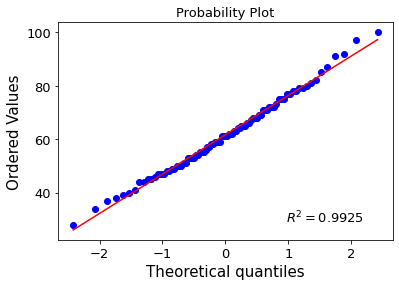

In [52]:
# could also inspect how the data is plotted against a hypothetical normal distribution, as follows

plt.figure()
probplot(data[data['race/ethnicity'] == 'group A']['math score'], dist = 'norm', plot = plt, rvalue = True)
plt.show()

From the above, we can see that the data is indeed normally distributed when separated by race/ethnicity

# Test for equality of variance between race/ethnicity groups

In [7]:
# Using Levene's test

# Levene null hypothesis is that the variance between groups IS equal
# reject the null hypothesis if the p-value is lower than the alpha

math_lval, math_pval = levene(data[data['race/ethnicity'] == 'group A']['math score'], 
       data[data['race/ethnicity'] == 'group B']['math score'],
       data[data['race/ethnicity'] == 'group C']['math score'], 
       data[data['race/ethnicity'] == 'group D']['math score'],
       data[data['race/ethnicity'] == 'group E']['math score'])

read_lval, read_pval = levene(data[data['race/ethnicity'] == 'group A']['reading score'], 
       data[data['race/ethnicity'] == 'group B']['reading score'],
       data[data['race/ethnicity'] == 'group C']['reading score'], 
       data[data['race/ethnicity'] == 'group D']['reading score'],
       data[data['race/ethnicity'] == 'group E']['reading score'])

write_lval, write_pval = levene(data[data['race/ethnicity'] == 'group A']['writing score'], 
       data[data['race/ethnicity'] == 'group B']['writing score'],
       data[data['race/ethnicity'] == 'group C']['writing score'], 
       data[data['race/ethnicity'] == 'group D']['writing score'],
       data[data['race/ethnicity'] == 'group E']['writing score'])

if math_pval < 0.01:
    print('levene stat:', round(math_lval, 3), 'p-val:', round(math_pval, 3), 
          'reject Levene NH for math scores: variances not equal')
else:
    print('levene stat:', round(math_lval, 3), 'p-val:', round(math_pval, 3),
          'fail to reject Levene NH for math scores: variances equal')
    
if read_pval < 0.01:
    print('levene stat:', round(read_lval, 3), 'p-val:', round(read_pval, 3),
          'reject Levene NH for reading scores: variances not equal')
else:
    print('levene stat:', round(read_lval, 3), 'p-val:', round(read_pval, 3),
          'fail to reject Levene NH for reading scores: variances equal')
    
if write_pval < 0.01:
    print('levene stat:', round(write_lval, 3), 'p-val:', round(write_pval, 3),
          'reject Levene NH for writing scores: variances not equal')
else:
    print('levene stat:', round(write_lval, 3), 'p-val:', round(write_pval, 3),
          'fail to reject Levene NH for writing scores: variances equal')    

levene stat: 0.59 p-val: 0.67 fail to reject Levene NH for math scores: variances equal
levene stat: 0.919 p-val: 0.452 fail to reject Levene NH for reading scores: variances equal
levene stat: 0.478 p-val: 0.752 fail to reject Levene NH for writing scores: variances equal


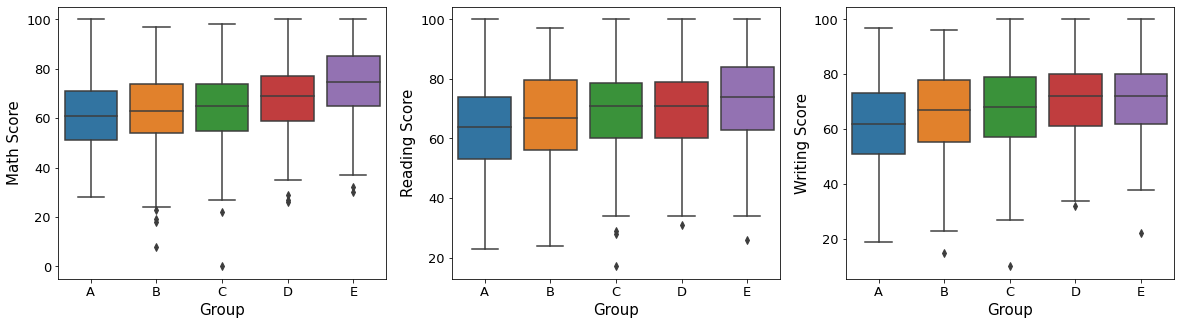

In [61]:
# can also visualise the variances with boxplots, as below

plt.figure(figsize = (20, 5))
plt.subplot(1, 3, 1)
ax = sns.boxplot(data = [data[data['race/ethnicity'] == 'group A']['math score'], 
       data[data['race/ethnicity'] == 'group B']['math score'],
       data[data['race/ethnicity'] == 'group C']['math score'], 
       data[data['race/ethnicity'] == 'group D']['math score'],
       data[data['race/ethnicity'] == 'group E']['math score']])

ax.set(xlabel = 'Group', xticklabels = ['A', 'B', 'C', 'D', 'E'], ylabel = 'Math Score')

plt.subplot(1, 3, 2)
ax = sns.boxplot(data = [data[data['race/ethnicity'] == 'group A']['reading score'], 
       data[data['race/ethnicity'] == 'group B']['reading score'],
       data[data['race/ethnicity'] == 'group C']['reading score'], 
       data[data['race/ethnicity'] == 'group D']['reading score'],
       data[data['race/ethnicity'] == 'group E']['reading score']])

ax.set(xlabel = 'Group', xticklabels = ['A', 'B', 'C', 'D', 'E'], ylabel = 'Reading Score')

plt.subplot(1, 3, 3)
ax = sns.boxplot(data = [data[data['race/ethnicity'] == 'group A']['writing score'], 
       data[data['race/ethnicity'] == 'group B']['writing score'],
       data[data['race/ethnicity'] == 'group C']['writing score'], 
       data[data['race/ethnicity'] == 'group D']['writing score'],
       data[data['race/ethnicity'] == 'group E']['writing score']])

ax.set(xlabel = 'Group', xticklabels = ['A', 'B', 'C', 'D', 'E'], ylabel = 'Writing Score')
plt.show()

From the above, we can see that the assumption of equality in variance between the groups does hold up for all three exams. Any difference observed can not be ruled out as solely due to random chance.

---

# Test for normality in gender groups

In [8]:
# reminder: Shapiro-Wilk test null hypothesis is that the data DOES follow normality

f_pvals = []
m_pvals = []

f_pvals.append(shapiro(data[data.gender == 'female']['math score']))
f_pvals.append(shapiro(data[data.gender == 'female']['reading score']))
f_pvals.append(shapiro(data[data.gender == 'female']['writing score']))

m_pvals.append(shapiro(data[data.gender == 'male']['math score']))
m_pvals.append(shapiro(data[data.gender == 'male']['reading score']))
m_pvals.append(shapiro(data[data.gender == 'male']['writing score']))

print('The normality test results for each gender are reported in the following order: math, reading, writing\n')

for i in f_pvals:
    if i[1] < 0.01:
        print('W-value:', round(i[0], 3), 'p-val:', i[1], 
              'reject Shapiro-Wilk (SW) null hypothesis (NH) for female scores: not normal')
    else:
        print('W-value:', round(i[0], 3), 'p-val:', i[1], 
              'fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for female scores: normal')
    
print()

for i in m_pvals:
    if i[1] < 0.01:
        print('W-value:', round(i[0], 3), 'p-val:', i[1],  
              'reject SW NH for male scores: not normal')
    else:
        print('W-value:', round(i[0], 3), 'p-val:', i[1],  
              'fail to reject SW NH for male scores: normal')

The normality test results for each gender are reported in the following order: math, reading, writing

W-value: 0.991 p-val: 0.0035164919681847095 reject Shapiro-Wilk (SW) null hypothesis (NH) for female scores: not normal
W-value: 0.985 p-val: 4.9554357246961445e-05 reject Shapiro-Wilk (SW) null hypothesis (NH) for female scores: not normal
W-value: 0.979 p-val: 9.895068160403753e-07 reject Shapiro-Wilk (SW) null hypothesis (NH) for female scores: not normal

W-value: 0.994 p-val: 0.03796108067035675 fail to reject SW NH for male scores: normal
W-value: 0.995 p-val: 0.08967796713113785 fail to reject SW NH for male scores: normal
W-value: 0.995 p-val: 0.10407906770706177 fail to reject SW NH for male scores: normal


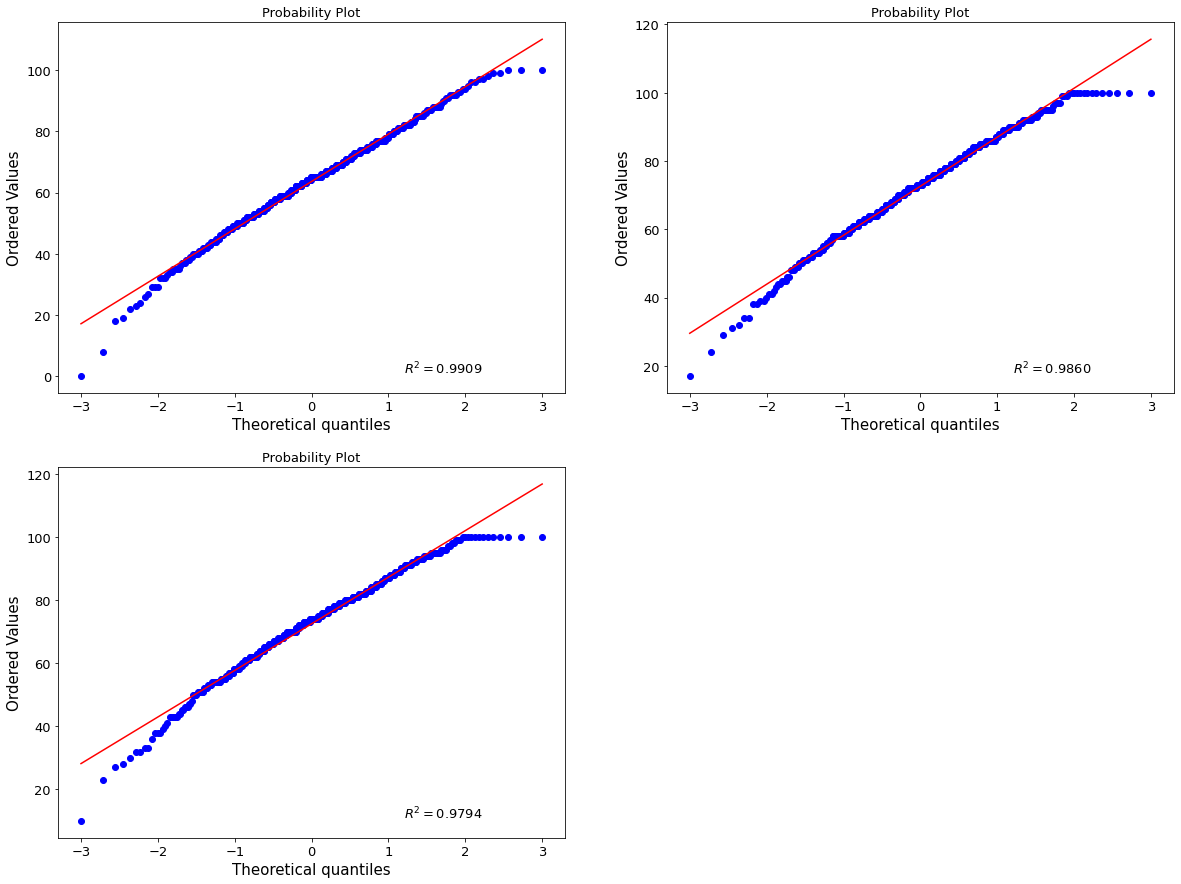

In [97]:
# all the female exam scores do not follow a normal distribution according to the shapiro-wilk test

# plot them below, against a theoretical normal distribution:

plt.figure(figsize = (20, 15))
plt.subplot(2, 2, 1)
probplot(data[data.gender == 'female']['math score'], dist = 'norm', plot = plt, rvalue = True)
plt.subplot(2, 2, 2)
probplot(data[data.gender == 'female']['reading score'], dist = 'norm', plot = plt, rvalue = True)
plt.subplot(2, 2, 3)
probplot(data[data.gender == 'female']['writing score'], dist = 'norm', plot = plt, rvalue = True)
plt.show()

According to the Shapiro-Wilk test, the male exam scores all follow normality. The female exam scores however, do not. 

Plotting the female exam scores against a theoretical normal distribution shows that they are not too far off, in that they all have high *R*<sup>2</sup> values.

The robustness of ANOVA tests to violations of normality has been tested extensively, as can be seen in the following article: http://www.psicothema.com/pdf/4434.pdf (*Psicothema 2017, Vol. 29, No. 4, 552-557*, doi: 10.7334/psicothema2016.383)

The authors found that in terms of type I error (false positives) the tests were robust in 100% of cases studied, regardless of violations of normality. 

As such, despite the female exam scores violating the assumption of normality, ANOVA should still provide an accurate test of differences in mean scores. It is however, something to keep in mind.

Violations of independence or equality of variance between groups would be more concerning, the former requiring the use of a repeated-measures ANOVA experiment, and the latter needing the use of a Welch ANOVA test instead of the regular ANOVA.


# Test for equality of variance between gender groups

In [9]:
# reminder: Levene's test null hypothesis is that the data DOES have equality of variance between groups

math_lstat, math_pval = levene(data[data.gender == 'female']['math score'], data[data.gender == 'male']['math score'])
read_lstat, read_pval = levene(data[data.gender == 'female']['reading score'], data[data.gender == 'male']['reading score'])
write_lstat, write_pval = levene(data[data.gender == 'female']['writing score'], data[data.gender == 'male']['writing score'])

if math_pval < 0.01:
    print(math_pval,
          'reject Levene NH - math score variance is not equal between gender groups')
else:
    print(math_pval, 
          'fail to reject Levene NH - math score variance is equal between gender groups')
    
if read_pval < 0.01:
    print(math_pval, 'reject Levene NH - reading score variance is not equal between gender groups')
else:
    print(math_pval, 'fail to reject Levene NH - reading score variance is equal between gender groups')
    
if write_pval < 0.01:
    print(math_pval, 'reject Levene NH - writing score variance is not equal between gender groups')
else:
    print(math_pval, 'fail to reject Levene NH - writing score variance is equal between gender groups')

0.55630915751998 fail to reject Levene NH - math score variance is equal between gender groups
0.55630915751998 fail to reject Levene NH - reading score variance is equal between gender groups
0.55630915751998 fail to reject Levene NH - writing score variance is equal between gender groups


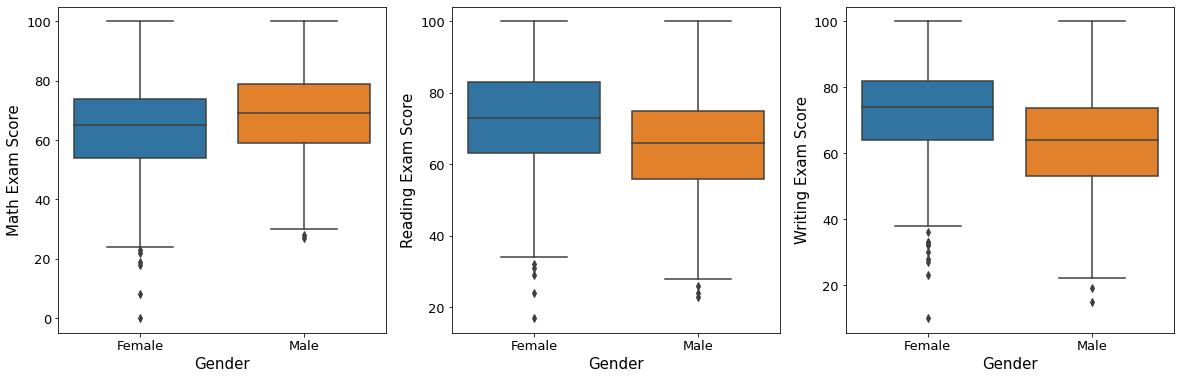

In [106]:
# and visualise the variances:

plt.figure(figsize = (20, 6))
plt.subplot(1, 3, 1)
ax = sns.boxplot(data = [data[data.gender == 'female']['math score'], data[data.gender == 'male']['math score']])
ax.set(xlabel = 'Gender', xticklabels = ['Female', 'Male'], ylabel = 'Math Exam Score')

plt.subplot(1, 3, 2)
ax = sns.boxplot(data = [data[data.gender == 'female']['reading score'], data[data.gender == 'male']['reading score']])
ax.set(xlabel = 'Gender', xticklabels = ['Female', 'Male'], ylabel = 'Reading Exam Score')

plt.subplot(1, 3, 3)
ax = sns.boxplot(data = [data[data.gender == 'female']['writing score'], data[data.gender == 'male']['writing score']])
ax.set(xlabel = 'Gender', xticklabels = ['Female', 'Male'], ylabel = 'Writing Exam Score')

plt.show()

Equality of variance between gender groups is confirmed.

---

# Test for normality in parental education groups

In [10]:
# reminder: Shapiro-Wilk test null hypothesis is that the data DOES follow normality

math_p_vals = []
read_p_vals = []
write_p_vals = []

for i in list(data['parental level of education'].unique()):
    math_p_vals.append(shapiro(data[data['parental level of education'] == i]['math score']))
    read_p_vals.append(shapiro(data[data['parental level of education'] == i]['reading score']))    
    write_p_vals.append(shapiro(data[data['parental level of education'] == i]['writing score']))

print('The following results for each exam are printed in the following order:',
     list(data['parental level of education'].unique()), ':\n')    

for p in math_p_vals:
    if p[1] < 0.01:
        print('W-value:', round(p[0], 3), 'p-value:', round(p[1], 3), 
              'reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: not normal')
    else:
        print('W-value:', round(p[0], 3), 'p-value:', round(p[1], 3), 
              'fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: normal')

print()
        
for p in read_p_vals:
    if p[1] < 0.01:
        print('W-value:', round(p[0], 3), 'p-value:', round(p[1], 3),
              'reject SW NH for reading scores: not normal')
    else:
        print('W-value:', round(p[0], 3), 'p-value:', round(p[1], 3),
              'fail to reject SW NH for reading scores: normal')
        
print()    

for p in write_p_vals:
    if p[1] < 0.01:
        print('W-value:', round(p[0], 3), 'p-value:', round(p[1], 3),
              'reject SW NH for writing scores: not normal')
    else:
        print('W-value:', round(p[0], 3), 'p-value:', round(p[1], 3),
              'fail to reject SW NH for writing scores: normal')

The following results for each exam are printed in the following order: ["bachelor's degree", 'some college', "master's degree", "associate's degree", 'high school', 'some high school'] :

W-value: 0.991 p-value: 0.604 fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: normal
W-value: 0.989 p-value: 0.096 fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: normal
W-value: 0.956 p-value: 0.032 fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: normal
W-value: 0.987 p-value: 0.045 fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: normal
W-value: 0.987 p-value: 0.065 fail to reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: normal
W-value: 0.977 p-value: 0.005 reject Shapiro-Wilk (SW) null hypothesis (NH) for math scores: not normal

W-value: 0.982 p-value: 0.122 fail to reject SW NH for reading scores: normal
W-value: 0.987 p-value: 0.038 fail to reject SW NH for reading scores: normal
W-value: 0

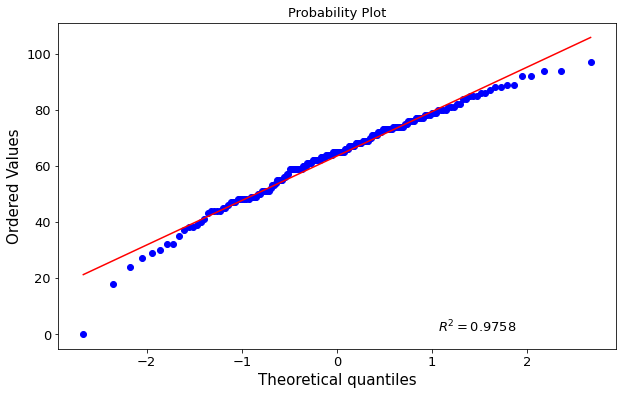

In [5]:
# all tests above showed normality, with the exception of the math scores for 'some high school'

# plot below against theoretical normal distribution

plt.figure(figsize = (10, 6))
probplot(data[data['parental level of education'] == 'some high school']['math score'],
         dist = 'norm', plot = plt, rvalue = True)
plt.show()

All except one test for normality within parental education groups showed normality. The math scores for a parental education level of 'some high school' did not however follow normality. 

When this data was plotted against a theoretical normal distribution, it, similarly to the female exam scores, had a high *R*<sup>2</sup> value, indicating it was not too far off.

For the same reasons as before, this small violation of the normality assumption is not enough to render ANOVA unsuitable.

# Test for equality of variance between parental education groups

In [11]:
# reminder: Levene null hypothesis is that the variance between groups IS equal
# reject the null hypothesis if the p-value is lower than the alpha

math_lval, math_pval = levene(data[data['parental level of education'] == 'bachelor\'s degree']['math score'], 
       data[data['parental level of education'] == 'some college']['math score'],
       data[data['parental level of education'] == 'master\'s degree']['math score'], 
       data[data['parental level of education'] == 'associate\'s degree']['math score'],
       data[data['parental level of education'] == 'high school']['math score'],
       data[data['parental level of education'] == 'some high school']['math score'])

read_lval, read_pval = levene(data[data['parental level of education'] == 'bachelor\'s degree']['reading score'], 
       data[data['parental level of education'] == 'some college']['reading score'],
       data[data['parental level of education'] == 'master\'s degree']['reading score'], 
       data[data['parental level of education'] == 'associate\'s degree']['reading score'],
       data[data['parental level of education'] == 'high school']['reading score'],
       data[data['parental level of education'] == 'some high school']['reading score'])

write_lval, write_pval = levene(data[data['parental level of education'] == 'bachelor\'s degree']['writing score'], 
       data[data['parental level of education'] == 'some college']['writing score'],
       data[data['parental level of education'] == 'master\'s degree']['writing score'], 
       data[data['parental level of education'] == 'associate\'s degree']['writing score'],
       data[data['parental level of education'] == 'high school']['writing score'],
       data[data['parental level of education'] == 'some high school']['writing score'])

if math_pval < 0.01:
    print('levene stat:', round(math_lval, 3), 'p-val:', round(math_pval, 3), 
          'reject Levene NH for math scores: variances not equal')
else:
    print('levene stat:', round(math_lval, 3), 'p-val:', round(math_pval, 3),
          'fail to reject Levene NH for math scores: variances equal')
    
if read_pval < 0.01:
    print('levene stat:', round(read_lval, 3), 'p-val:', round(read_pval, 3),
          'reject Levene NH for reading scores: variances not equal')
else:
    print('levene stat:', round(read_lval, 3), 'p-val:', round(read_pval, 3),
          'fail to reject Levene NH for reading scores: variances equal')
    
if write_pval < 0.01:
    print('levene stat:', round(write_lval, 3), 'p-val:', round(write_pval, 3),
          'reject Levene NH for writing scores: variances not equal')
else:
    print('levene stat:', round(write_lval, 3), 'p-val:', round(write_pval, 3),
          'fail to reject Levene NH for writing scores: variances equal')  

levene stat: 0.933 p-val: 0.458 fail to reject Levene NH for math scores: variances equal
levene stat: 0.408 p-val: 0.844 fail to reject Levene NH for reading scores: variances equal
levene stat: 0.693 p-val: 0.628 fail to reject Levene NH for writing scores: variances equal


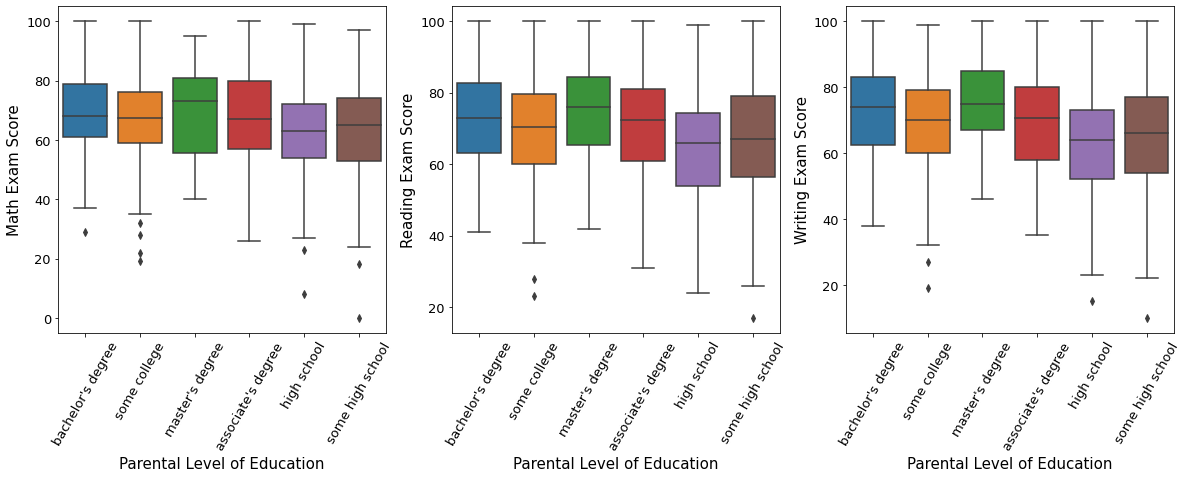

In [61]:
# and visualise the variances:

plt.figure(figsize = (20, 6))
plt.subplot(1, 3, 1)
ax = sns.boxplot(data = [data[data['parental level of education'] == 'bachelor\'s degree']['math score'], 
       data[data['parental level of education'] == 'some college']['math score'],
       data[data['parental level of education'] == 'master\'s degree']['math score'], 
       data[data['parental level of education'] == 'associate\'s degree']['math score'],
       data[data['parental level of education'] == 'high school']['math score'],
       data[data['parental level of education'] == 'some high school']['math score']])
ax.set(xlabel = 'Parental Level of Education', xticklabels = data['parental level of education'].unique(),
       ylabel = 'Math Exam Score')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60)

plt.subplot(1, 3, 2)
ax = sns.boxplot(data = [data[data['parental level of education'] == 'bachelor\'s degree']['reading score'], 
       data[data['parental level of education'] == 'some college']['reading score'],
       data[data['parental level of education'] == 'master\'s degree']['reading score'], 
       data[data['parental level of education'] == 'associate\'s degree']['reading score'],
       data[data['parental level of education'] == 'high school']['reading score'],
       data[data['parental level of education'] == 'some high school']['reading score']])
ax.set(xlabel = 'Parental Level of Education', xticklabels = data['parental level of education'].unique(),
       ylabel = 'Reading Exam Score')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60)

plt.subplot(1, 3, 3)
ax = sns.boxplot(data = [data[data['parental level of education'] == 'bachelor\'s degree']['writing score'], 
       data[data['parental level of education'] == 'some college']['writing score'],
       data[data['parental level of education'] == 'master\'s degree']['writing score'], 
       data[data['parental level of education'] == 'associate\'s degree']['writing score'],
       data[data['parental level of education'] == 'high school']['writing score'],
       data[data['parental level of education'] == 'some high school']['writing score']])
ax.set(xlabel = 'Parental Level of Education', xticklabels = data['parental level of education'].unique(),
       ylabel = 'Writing Exam Score')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60)

plt.show()

The above results show that the assumption of equality of variance between parental education groups is indeed met/satisfied. Any difference can not be ruled out as being solely due to random chance.

---

# *n*-way ANOVA

We will now compare the means of the different groups through *n*-way ANOVA.

There are two packages commonly used to implement *n*-way ANOVA in Python: statsmodels and pingouin. We will use both to help verify the results.

We will be using an alpha of 0.01, consistent with the tests above.

In [12]:
# data is already in required stacked format (independent variable groups are within columns)
# therefore no need to pd.melt() ('unpivot')

# we do need to remove spaces in column names though

n_way = data.rename(columns = {'race/ethnicity':'race_ethnicity', 
                               'parental level of education':'parental_education', 'math score':'math_score',
                               'reading score':'reading_score', 'writing score':'writing_score'})

n_way.columns

Index(['gender', 'race_ethnicity', 'parental_education', 'lunch',
       'test preparation course', 'math_score', 'reading_score',
       'writing_score'],
      dtype='object')

# ANOVA using statsmodels:

In [14]:
# math score 3-way ANOVA

math_model = ols('math_score ~ C(gender) * C(race_ethnicity) * C(parental_education)', data = n_way).fit()

math_anova_table = sm.stats.anova_lm(math_model, typ = 2)

print('N-way ANOVA results for gender, parental education, and race/ethnicity group on mean math score:')
math_anova_table

N-way ANOVA results for gender, parental education, and race/ethnicity group on mean math score:


,sum_sq,df,F,PR(>F)
C(gender),7115.831280,1.0,34.071540,7.308826e-09
C(race_ethnicity),10876.748196,4.0,13.019827,2.527894e-10
C(parental_education),6379.883619,5.0,6.109545,1.403329e-05
C(gender):C(race_ethnicity),175.100851,4.0,0.209602,9.331550e-01
C(gender):C(parental_education),1184.539584,5.0,1.134346,3.403289e-01
C(race_ethnicity):C(parental_education),1868.690215,20.0,0.447377,9.830199e-01
C(gender):C(race_ethnicity):C(parental_education),4949.363559,20.0,1.184910,2.590381e-01
Residual,196318.725874,940.0,NaN,NaN


In [15]:
# statistically significant differences for mean math scores

print('The statistically significant differences between groups for the mean math scores are:')
math_anova_table[math_anova_table['PR(>F)'] < 0.01]

The statistically significant differences between groups for the mean math scores are:


,sum_sq,df,F,PR(>F)
C(gender),7115.831280,1.0,34.071540,7.308826e-09
C(race_ethnicity),10876.748196,4.0,13.019827,2.527894e-10
C(parental_education),6379.883619,5.0,6.109545,1.403329e-05


In [16]:
# reading score n-way ANOVA

read_model = ols('reading_score ~ C(gender) * C(race_ethnicity) * C(parental_education)', data = n_way).fit()

read_anova_table = sm.stats.anova_lm(read_model, typ = 2)

print('N-way ANOVA results for gender, parental education, and race/ethnicity group on mean reading score:')
read_anova_table

N-way ANOVA results for gender, parental education, and race/ethnicity group on mean reading score:


,sum_sq,df,F,PR(>F)
C(gender),10765.615113,1.0,56.336394,1.415676e-13
C(race_ethnicity),3545.087612,4.0,4.637855,1.035151e-03
C(parental_education),7426.784195,5.0,7.772863,3.531870e-07
C(gender):C(race_ethnicity),330.325531,4.0,0.432148,7.854724e-01
C(gender):C(parental_education),961.436174,5.0,1.006238,4.127431e-01
C(race_ethnicity):C(parental_education),1952.123612,20.0,0.510773,9.632619e-01
C(gender):C(race_ethnicity):C(parental_education),5654.306113,20.0,1.479447,7.998597e-02
Residual,179629.498207,940.0,NaN,NaN


In [17]:
# statistically significant differences for mean reading scores

print('The statistically significant differences between groups for the mean reading scores are:')
read_anova_table[read_anova_table['PR(>F)'] < 0.01]

The statistically significant differences between groups for the mean reading scores are:


,sum_sq,df,F,PR(>F)
C(gender),10765.615113,1.0,56.336394,1.415676e-13
C(race_ethnicity),3545.087612,4.0,4.637855,1.035151e-03
C(parental_education),7426.784195,5.0,7.772863,3.531870e-07


In [18]:
# writing score n-way ANOVA

write_model = ols('writing_score ~ C(gender) * C(race_ethnicity) * C(parental_education)', data = n_way).fit()

write_anova_table = sm.stats.anova_lm(write_model, typ = 2)

print('N-way ANOVA results for gender, parental education, and race/ethnicity group on mean writing score:')
write_anova_table

N-way ANOVA results for gender, parental education, and race/ethnicity group on mean writing score:


,sum_sq,df,F,PR(>F)
C(gender),18051.915312,1.0,92.374308,6.330604e-21
C(race_ethnicity),4840.241169,4.0,6.192057,6.418500e-05
C(parental_education),12317.836751,5.0,12.606437,7.180799e-12
C(gender):C(race_ethnicity),147.502163,4.0,0.188698,9.443396e-01
C(gender):C(parental_education),961.920574,5.0,0.984458,4.260597e-01
C(race_ethnicity):C(parental_education),2047.137715,20.0,0.523775,9.577997e-01
C(gender):C(race_ethnicity):C(parental_education),4407.080999,20.0,1.127584,3.141128e-01
Residual,183696.103443,940.0,NaN,NaN


In [19]:
# statistically significant differences for mean writing scores

print('The statistically significant differences between groups for the mean writing scores are:')
write_anova_table[write_anova_table['PR(>F)'] < 0.01]

The statistically significant differences between groups for the mean writing scores are:


,sum_sq,df,F,PR(>F)
C(gender),18051.915312,1.0,92.374308,6.330604e-21
C(race_ethnicity),4840.241169,4.0,6.192057,6.418500e-05
C(parental_education),12317.836751,5.0,12.606437,7.180799e-12


# ANOVA using pingouin:

In [32]:
# math score 3-way ANOVA

math_anova = pg.anova(data = n_way, dv = 'math_score', 
                      between = ['gender', 'race_ethnicity', 'parental_education'], effsize = 'n2')
math_anova

,Source,SS,DF,MS,F,p-unc,n2
0,gender,7115.831280,1.0,7115.831280,34.071540,7.308826e-09,0.031091
1,race_ethnicity,10876.748196,4.0,2719.187049,13.019827,2.527894e-10,0.047524
2,parental_education,6379.883619,5.0,1275.976724,6.109545,1.403329e-05,0.027876
3,gender * race_ethnicity,175.100851,4.0,43.775213,0.209602,9.331550e-01,0.000765
4,gender * parental_education,1184.539584,5.0,236.907917,1.134346,3.403289e-01,0.005176
5,race_ethnicity * parental_education,1868.690215,20.0,93.434511,0.447377,9.830199e-01,0.008165
6,gender * race_ethnicity * parental_education,4949.363559,20.0,247.468178,1.184910,2.590381e-01,0.021625
7,Residual,196318.725874,940.0,208.849708,NaN,NaN,NaN


In [33]:
print('The statistically significant differences between groups for the mean math scores are:')
math_anova[math_anova['p-unc'] < 0.01]

The statistically significant differences between groups for the mean math scores are:


,Source,SS,DF,MS,F,p-unc,n2
0,gender,7115.831280,1.0,7115.831280,34.071540,7.308826e-09,0.031091
1,race_ethnicity,10876.748196,4.0,2719.187049,13.019827,2.527894e-10,0.047524
2,parental_education,6379.883619,5.0,1275.976724,6.109545,1.403329e-05,0.027876


In [30]:
# reading score 3-way ANOVA

read_anova = pg.anova(data = n_way, dv = 'reading_score', 
                      between = ['gender', 'race_ethnicity', 'parental_education'], effsize = 'n2')
read_anova

,Source,SS,DF,MS,F,p-unc,n2
0,gender,10765.615113,1.0,10765.615113,56.336394,1.415676e-13,0.051200
1,race_ethnicity,3545.087612,4.0,886.271903,4.637855,1.035151e-03,0.016860
2,parental_education,7426.784195,5.0,1485.356839,7.772863,3.531870e-07,0.035321
3,gender * race_ethnicity,330.325531,4.0,82.581383,0.432148,7.854724e-01,0.001571
4,gender * parental_education,961.436174,5.0,192.287235,1.006238,4.127431e-01,0.004572
5,race_ethnicity * parental_education,1952.123612,20.0,97.606181,0.510773,9.632619e-01,0.009284
6,gender * race_ethnicity * parental_education,5654.306113,20.0,282.715306,1.479447,7.998597e-02,0.026891
7,Residual,179629.498207,940.0,191.095211,NaN,NaN,NaN


In [31]:
print('The statistically significant differences between groups for the mean reading scores are:')
read_anova[read_anova['p-unc'] < 0.01]

The statistically significant differences between groups for the mean reading scores are:


,Source,SS,DF,MS,F,p-unc,n2
0,gender,10765.615113,1.0,10765.615113,56.336394,1.415676e-13,0.051200
1,race_ethnicity,3545.087612,4.0,886.271903,4.637855,1.035151e-03,0.016860
2,parental_education,7426.784195,5.0,1485.356839,7.772863,3.531870e-07,0.035321


In [28]:
# writing score 3-way ANOVA

write_anova = pg.anova(data = n_way, dv = 'writing_score', 
                       between = ['gender', 'race_ethnicity', 'parental_education'], effsize = 'n2')
write_anova

,Source,SS,DF,MS,F,p-unc,n2
0,gender,18051.915312,1.0,18051.915312,92.374308,6.330604e-21,0.079710
1,race_ethnicity,4840.241169,4.0,1210.060292,6.192057,6.418500e-05,0.021373
2,parental_education,12317.836751,5.0,2463.567350,12.606437,7.180799e-12,0.054391
3,gender * race_ethnicity,147.502163,4.0,36.875541,0.188698,9.443396e-01,0.000651
4,gender * parental_education,961.920574,5.0,192.384115,0.984458,4.260597e-01,0.004247
5,race_ethnicity * parental_education,2047.137715,20.0,102.356886,0.523775,9.577997e-01,0.009039
6,gender * race_ethnicity * parental_education,4407.080999,20.0,220.354050,1.127584,3.141128e-01,0.019460
7,Residual,183696.103443,940.0,195.421387,NaN,NaN,NaN


In [29]:
print('The statistically significant differences between groups for the mean writing scores are:')
write_anova[write_anova['p-unc'] < 0.01]

The statistically significant differences between groups for the mean writing scores are:


,Source,SS,DF,MS,F,p-unc,n2
0,gender,18051.915312,1.0,18051.915312,92.374308,6.330604e-21,0.079710
1,race_ethnicity,4840.241169,4.0,1210.060292,6.192057,6.418500e-05,0.021373
2,parental_education,12317.836751,5.0,2463.567350,12.606437,7.180799e-12,0.054391


These tests returned the same results as for the statsmodels approach. I believe pingouin calls statsmodels itself for n-way ANOVA with n above 2, so this is perhaps unsurprising. It is still useful to verify that the input has been submitted correctly.

The pingouin approach does automatically calculate the η<sup>2</sup> effect size metric though, which statsmodels does not by default.

# Results:

For all exam scores, the only statistically significant differences found (alpha = 0.01) were between gender groups, between race/ethnicity groups, and between parental education groups. 

For both reading and writing scores, the effect size varied in the following order: gender > parental education > race/ethnicity. For math scores however, race/ethnicity had the largest effect, followed by gender and then parental education, the latter two having quite similarly sized effects.

No significant differences were found when considering more than one independent variable at a time (e.g. gender *and* race/ethnicity, or race/ethnicity *and* parental education).

---

# Post-hoc tests: Tukey Honestly Significant Difference (HSD)

To gain information on *how* the mean scores varied, we need to perform a further test.

We will perform a Tukey-HSD test for each group/exam combination, all with an alpha of 0.01 for consistency.

# Race/ethnicity groups:

In [101]:
math_tukey_results = pairwise_tukeyhsd(data['math score'], data['race/ethnicity'], alpha = 0.01)

print('Tukey results for math scores:')
math_tukey_results.summary()

Tukey results for math scores:


group1,group2,meandiff,p-adj,lower,upper,reject
group A,group B,1.8234,0.8597,-4.3667,8.0136,False
group A,group C,2.8347,0.4966,-2.9424,8.6119,False
group A,group D,5.7334,0.0138,-0.1792,11.646,False
group A,group E,12.1922,0.001,5.6589,18.7255,True
group B,group C,1.0113,0.9,-3.405,5.4276,False
group B,group D,3.91,0.0441,-0.6822,8.5021,False
group B,group E,10.3688,0.001,5.0011,15.7365,True
group C,group D,2.8986,0.1287,-1.1194,6.9167,False
group C,group E,9.3575,0.001,4.4719,14.2431,True
group D,group E,6.4588,0.001,1.4137,11.5039,True


In [102]:
read_tukey_results = pairwise_tukeyhsd(data['reading score'], data['race/ethnicity'], alpha = 0.01)

print('Tukey results for reading scores:')
read_tukey_results.summary()

Tukey results for reading scores:


group1,group2,meandiff,p-adj,lower,upper,reject
group A,group B,2.6785,0.5875,-3.3861,8.743,False
group A,group C,4.4293,0.0801,-1.2306,10.0892,False
group A,group D,5.3564,0.0219,-0.4363,11.149,False
group A,group E,8.3544,0.001,1.9537,14.7551,True
group B,group C,1.7508,0.656,-2.5759,6.0775,False
group B,group D,2.6779,0.2956,-1.8211,7.1769,False
group B,group E,5.6759,0.0041,0.4171,10.9347,True
group C,group D,0.9271,0.9,-3.0094,4.8636,False
group C,group E,3.9251,0.0583,-0.8614,8.7116,False
group D,group E,2.998,0.2768,-1.9447,7.9408,False


In [103]:
write_tukey_results = pairwise_tukeyhsd(data['writing score'], data['race/ethnicity'], alpha = 0.01)

print('Tukey results for writing scores:')
write_tukey_results.summary()

Tukey results for writing scores:


group1,group2,meandiff,p-adj,lower,upper,reject
group A,group B,2.9258,0.5444,-3.367,9.2187,False
group A,group C,5.1534,0.0346,-0.7196,11.0264,False
group A,group D,7.4709,0.001,1.4601,13.4816,True
group A,group E,8.733,0.001,2.0913,15.3747,True
group B,group C,2.2276,0.4857,-2.262,6.7172,False
group B,group D,4.545,0.0133,-0.1233,9.2134,False
group B,group E,5.8071,0.0049,0.3504,11.2639,True
group C,group D,2.3175,0.3448,-1.7673,6.4022,False
group C,group E,3.5796,0.1294,-1.3871,8.5462,False
group D,group E,1.2621,0.9,-3.8667,6.3909,False


# Results for race/ethnicity groups:

The 'reject' column refers to whether or not we should reject the null hypothesis that the group means are not statistically signficantly different.

As such, we can see that there were statistically significant differences between the following:

Math scores: groups A & E, B & E, C & E, and D & E

Reading scores: groups A & E, and B & E

Writing scores: groups A & D, A & E, and B & E

For clarity, the significant results have been extracted below, ordered by the difference in means.

In [106]:
re_signif_math = pd.DataFrame(data = math_tukey_results._results_table.data[1:], 
                            columns = math_tukey_results._results_table.data[0])

re_signif_math[re_signif_math.reject == True].sort_values('meandiff', ascending = False)

,group1,group2,meandiff,p-adj,lower,upper,reject
3,group A,group E,12.1922,0.001,5.6589,18.7255,True
6,group B,group E,10.3688,0.001,5.0011,15.7365,True
8,group C,group E,9.3575,0.001,4.4719,14.2431,True
9,group D,group E,6.4588,0.001,1.4137,11.5039,True


In [105]:
re_signif_read = pd.DataFrame(data = read_tukey_results._results_table.data[1:], 
                            columns = read_tukey_results._results_table.data[0])

re_signif_read[re_signif_read.reject == True].sort_values('meandiff', ascending = False)

,group1,group2,meandiff,p-adj,lower,upper,reject
3,group A,group E,8.3544,0.0010,1.9537,14.7551,True
6,group B,group E,5.6759,0.0041,0.4171,10.9347,True


In [104]:
re_signif_write = pd.DataFrame(data = write_tukey_results._results_table.data[1:], 
                            columns = write_tukey_results._results_table.data[0])

re_signif_write[re_signif_write.reject == True].sort_values('meandiff', ascending = False)

,group1,group2,meandiff,p-adj,lower,upper,reject
3,group A,group E,8.7330,0.0010,2.0913,15.3747,True
2,group A,group D,7.4709,0.0010,1.4601,13.4816,True
6,group B,group E,5.8071,0.0049,0.3504,11.2639,True


There were more significant differences between race/ethnicity groups for math scores than there were for writing, and then reading.

Group E scored statistically significantly higher on average than all other ethnicities for math. The other groups did not score significantly different on average from each other.

Group E also scored statistically significantly higher on average than groups A and B for reading.
This was also true for writing, in which Group D also scored higher than group A.

No other significant differences were found between groups.

---

# Gender groups:

In [38]:
# tukey-hsd for gender

print('Tukey-HSD results for math scores:')
pairwise_tukeyhsd(data['math score'], data['gender'], alpha = 0.01).summary()

Tukey-HSD results for math scores:


group1,group2,meandiff,p-adj,lower,upper,reject
female,male,5.095,0.001,2.6524,7.5376,True


In [39]:
print('Tukey-HSD results for reading scores:')
pairwise_tukeyhsd(data['reading score'], data['gender'], alpha = 0.01).summary()

Tukey-HSD results for reading scores:


group1,group2,meandiff,p-adj,lower,upper,reject
female,male,-7.1351,0.001,-9.4486,-4.8216,True


In [40]:
print('Tukey-HSD results for writing scores:')
pairwise_tukeyhsd(data['writing score'], data['gender'], alpha = 0.01).summary()

Tukey-HSD results for writing scores:


group1,group2,meandiff,p-adj,lower,upper,reject
female,male,-9.156,0.001,-11.5238,-6.7882,True


# Results for gender groups:

We can see that there were statistically significant differences between female and male exam scores for all three subjects.

Females were on average better at reading and writing, and males at math.

---

# Parental education groups:

In [85]:
print('Tukey-HSD results for whether race/ethnicity groups affect mean math scores')
pe_math_tukey = pairwise_tukeyhsd(data['math score'], data['parental level of education'], alpha = 0.01)
pe_math_tukey.summary()

Tukey-HSD results for whether race/ethnicity groups affect mean math scores


group1,group2,meandiff,p-adj,lower,upper,reject
associate's degree,bachelor's degree,1.5069,0.9,-4.2416,7.2555,False
associate's degree,high school,-5.7451,0.0013,-10.6907,-0.7996,True
associate's degree,master's degree,1.8629,0.9,-5.5278,9.2535,False
associate's degree,some college,-0.7546,0.9,-5.5226,4.0135,False
associate's degree,some high school,-4.3857,0.0418,-9.4544,0.6831,False
bachelor's degree,high school,-7.2521,0.001,-13.1314,-1.3727,True
bachelor's degree,master's degree,0.3559,0.9,-7.6896,8.4014,False
bachelor's degree,some college,-2.2615,0.7401,-7.9923,3.4693,False
bachelor's degree,some high school,-5.8926,0.0119,-11.876,0.0907,False
high school,master's degree,7.608,0.0084,0.1151,15.1009,True


In [84]:
print('Tukey-HSD results for whether race/ethnicity groups affect mean reading scores')
pe_read_tukey = pairwise_tukeyhsd(data['reading score'], data['parental level of education'], alpha = 0.01)
pe_read_tukey.summary()

Tukey-HSD results for whether race/ethnicity groups affect mean reading scores


group1,group2,meandiff,p-adj,lower,upper,reject
associate's degree,bachelor's degree,2.0721,0.7746,-3.4261,7.5702,False
associate's degree,high school,-6.2238,0.001,-10.954,-1.4936,True
associate's degree,master's degree,4.445,0.2771,-2.6239,11.5138,False
associate's degree,some college,-1.4678,0.8816,-6.0282,3.0927,False
associate's degree,some high school,-3.9894,0.0623,-8.8374,0.8587,False
bachelor's degree,high school,-8.2959,0.001,-13.9192,-2.6726,True
bachelor's degree,master's degree,2.3729,0.9,-5.3222,10.068,False
bachelor's degree,some college,-3.5398,0.2486,-9.0211,1.9414,False
bachelor's degree,some high school,-6.0615,0.005,-11.7842,-0.3387,True
high school,master's degree,10.6688,0.001,3.5022,17.8354,True


In [81]:
print('Tukey-HSD results for whether race/ethnicity groups affect mean writing scores')
pe_write_tukey = pairwise_tukeyhsd(data['writing score'], data['parental level of education'], alpha = 0.01)
pe_write_tukey.summary()

Tukey-HSD results for whether race/ethnicity groups affect mean writing scores


group1,group2,meandiff,p-adj,lower,upper,reject
associate's degree,bachelor's degree,3.485,0.2988,-2.1679,9.1378,False
associate's degree,high school,-7.4474,0.001,-12.3107,-2.5841,True
associate's degree,master's degree,5.7816,0.0797,-1.4861,13.0493,False
associate's degree,some college,-1.0557,0.9,-5.7444,3.633,False
associate's degree,some high school,-5.0081,0.0095,-9.9925,-0.0237,True
bachelor's degree,high school,-10.9324,0.001,-16.7139,-5.1509,True
bachelor's degree,master's degree,2.2966,0.9,-5.615,10.2082,False
bachelor's degree,some college,-4.5406,0.0728,-10.1761,1.0948,False
bachelor's degree,some high school,-8.4931,0.001,-14.3769,-2.6093,True
high school,master's degree,13.229,0.001,5.8608,20.5972,True


# Results for parental eduction groups:

There are many levels of parental education, and correpsondingly many pairs. We can improve the clarity of the results by showing only those pairs which show statistically significant differences, and order them by the difference in means:

In [100]:
signif_math = pd.DataFrame(data = pe_math_tukey._results_table.data[1:], 
                            columns = pe_math_tukey._results_table.data[0])

signif_math[signif_math.reject == True].sort_values('meandiff', ascending = False)

,group1,group2,meandiff,p-adj,lower,upper,reject
9,high school,master's degree,7.6080,0.0084,0.1151,15.1009,True
10,high school,some college,4.9906,0.0086,0.0656,9.9156,True
1,associate's degree,high school,-5.7451,0.0013,-10.6907,-0.7996,True
5,bachelor's degree,high school,-7.2521,0.0010,-13.1314,-1.3727,True


In [99]:
signif_read = pd.DataFrame(data = pe_read_tukey._results_table.data[1:], 
                            columns = pe_read_tukey._results_table.data[0])

signif_read[signif_read.reject == True].sort_values('meandiff', ascending = False)

,group1,group2,meandiff,p-adj,lower,upper,reject
9,high school,master's degree,10.6688,0.0010,3.5022,17.8354,True
10,high school,some college,4.7561,0.0089,0.0456,9.4666,True
8,bachelor's degree,some high school,-6.0615,0.0050,-11.7842,-0.3387,True
1,associate's degree,high school,-6.2238,0.0010,-10.9540,-1.4936,True
5,bachelor's degree,high school,-8.2959,0.0010,-13.9192,-2.6726,True
13,master's degree,some high school,-8.4343,0.0013,-15.6792,-1.1894,True


In [98]:
signif_write = pd.DataFrame(data = pe_write_tukey._results_table.data[1:], 
                            columns = pe_write_tukey._results_table.data[0])

signif_write[signif_write.reject == True].sort_values('meandiff', ascending = False)

,group1,group2,meandiff,p-adj,lower,upper,reject
9,high school,master's degree,13.2290,0.0010,5.8608,20.5972,True
10,high school,some college,6.3917,0.0010,1.5487,11.2348,True
4,associate's degree,some high school,-5.0081,0.0095,-9.9925,-0.0237,True
1,associate's degree,high school,-7.4474,0.0010,-12.3107,-2.5841,True
8,bachelor's degree,some high school,-8.4931,0.0010,-14.3769,-2.6093,True
13,master's degree,some high school,-10.7897,0.0010,-18.2384,-3.3410,True
5,bachelor's degree,high school,-10.9324,0.0010,-16.7139,-5.1509,True


# Parental Education results continued:

From inspection, we can see that statistically significant differences in mean exam scores (for either subject) tend to occur between students whose parents have 'high school' or 'some high school' levels of education, and those whose parents have higher levels of education. Namely, the groups of students whose parents have higher levels of education tend to do better than those whose parents do not.

There was not a significant difference observed between children whose parents have differing levels of higher education, in either subject.

There was also not a significant difference observed between children whose parents had only high school level education, and those whose parents only had 'some high school' education.